# The Hill-Tononi Neuron and Synapse Models

Hans Ekkehard Plesser, 2016-11-24

This notebook describes the neuron and synapse model proposed by Hill and Tononi in *J Neurophysiol* 93:1671-1698, 2005 ([doi:10.1152/jn.00915.2004](http://dx.doi.org/doi:10.1152/jn.00915.2004)) and their implementation in NEST. The notebook also contains some tests.

This description is based on the original publication and publications cited therein, an analysis of the source code of the original Synthesis implementation kindly provided by Sean Hill, and plausiblity arguments.

In what follows, I will refer to the original paper as [HT05].

## The Neuron Model

### Integration 

The original Synthesis implementation of the model uses Runge-Kutta integration with fixed 0.25 ms step size, and integrates channels dynamics first, followed by integration of membrane potential and threshold.

NEST, in contrast, integrates the complete 16-dimensional state using a single adaptive-stepsize Runge-Kutta solver.

### Membrane potential

Membrane potential evolution is goverened by [HT05, p 1677]

\begin{equation}
\frac{\text{d}V}{\text{d}t} = \frac{-g_{\text{NaL}}(V-E_{\text{Na}})
-g_{\text{KL}}(V-E_{\text{K}})+I_{\text{syn}}+I_{\text{int}}}{\tau_{\text{m}}}
-\frac{g_{\text{spike}}(V-E_{\text{K}})}{\tau_{\text{spike}}}
\end{equation}

- The equation does not contain membrane capacitance. As a side-effect, all conductances are dimensionless.
- Na and K leak conductances $g_{\text{NaL}}$ and $g_{\text{KL}}$ are constant, although $g_{\text{KL}}$ may be adjusted on slow time scales to mimic neuromodulatory effects.
- Reversal potentials are assumed constant.
- Synaptic currents $I_{\text{syn}}$ and intrinsic currents $I_{\text{int}}$ are discussed below. In contrast to the paper, they are shown with positive sign here (just change in notation).
- The last term is a re-polarizing current only active during the refractory period, see below. Note that it has a different (faster) time constant than the other currents. It might have been more natural to use the same time constant for all currents and instead adjust $g_{\text{spike}}$. We follow the original approach here.

### Threshold, Spike generation and refractory effects

The threshold evolves according to [HT05, p 1677]

\begin{equation}
\frac{\text{d}\theta}{\text{d}t} = -\frac{\theta-\theta_{\text{eq}}}{\tau_{\theta}}
\end{equation}

The neuron emits a single spike if 
- it is not refractory
- membrane potential crosses the threshold, $V\geq\theta$

Upon spike emission,
- $V \leftarrow E_{\text{Na}}$
- $\theta \leftarrow E_{\text{Na}}$
- the neuron becomes refractory for time $t_{\text{spike}}$ (`t_ref` in NEST)

The repolarizing current is active during, and only during the refractory period:
\begin{equation}
g_{\text{spike}} = \begin{cases}  1  & \text{neuron is refractory}\\
 0 & \text{else} \end{cases}
\end{equation}

During the refractory period, the neuron cannot fire new spikes, but all state variables evolve freely, nothing is clamped. 

The model of spiking and refractoriness is based on Synthesis model `PulseIntegrateAndFire`.

### Intrinsic currents

Note that not all intrinsic currents are active in all populations of the network model presented in [HT05, p1678f].

Intrinsic currents are based on the Hodgkin-Huxley description, i.e.,

\begin{align}
I_X &= g_{\text{peak}, X} m_X(V, t)^N_X h_X(V, t)(V-E_X) \\
\frac{\text{d}m_X}{\text{d}t} &= \frac{m_X^{\infty}-m_X}{\tau_{m,X}(V)}\\
\frac{\text{d}h_X}{\text{d}t} &= \frac{h_X^{\infty}-h_X}{\tau_{h,X}(V)}
\end{align}

#### Pacemaker current $I_h$

Synthesis: `IhChannel`

\begin{align}
N_h & = 1 \\
m_h^{\infty}(V) &= \frac{1}{1+\exp\left(\frac{V+75\text{mV}}{5.5\text{mV}}\right)} \\
\tau_{m,h}(V) &= \frac{1}{\exp(-14.59-0.086V) + \exp(-1.87  + 0.0701V)} \\
h_h(V, t) &\equiv 1 
\end{align}

Note that subscript $h$ in some cases above marks the $I_h$ channel, 

#### Low-threshold calcium current $I_T$

Synthesis: `ItChannel`

##### Equations given in paper 

\begin{align}
N_T & \quad \text{not given} \\
m_T^{\infty}(V) &= 1/\{1 +  \exp[ -(V +  59.0)/6.2]\} \\
\tau_{m,T}(V) &= \{0.22/\exp[ -(V  + 132.0)/ 16.7]\} +  \exp[(V  + 16.8)/18.2] +  0.13\\
h_T^{\infty}(V) &= 1/\{1 +  \exp[(V +  83.0)/4.0]\} \\
\tau_{h,T}(V) &= \langle  8.2 +  \{56.6 +  0.27 \exp[(V +  115.2)/5.0]\}\rangle / \{1.0 +  \exp[(V +  86.0)/3.2]\}
\end{align}

Note the following:
- $N_T=2$ from Synthesis code
- In the equation for $\tau_{m,T}$, the second exponential term must be added to the first (in the denominator) to make dimensional sense; 0.13 and 0.22 have unit ms.
- In the equation for $\tau_{h,T}$, the $\langle \rangle$ brackets should be dropped, so that $8.2$ is not divided by the $1+\exp$ term. Otherwise, it could have been combined with the $56.6$.
- This analysis is confirmed by code analysis and comparison with Destexhe et al, *J Neurophysiol* 76:2049 (1996), Eq 5, as cited by [HT05].

##### Corrected equations

This leads to the following equations, which are implemented in Synthesis and NEST.

\begin{align}
N_T &= 2 \\
m_T^{\infty}(V) &=  \frac{1}{1+\exp\left(-\frac{V+59\text{mV}}{6.2\text{mV}}\right)}\\
\tau_{m,T}(V) &= 0.13\text{ms} 
  + \frac{0.22\text{ms}}{\exp\left(-\frac{V  + 132\text{mV}}{16.7\text{mV}}\right) + \exp\left(\frac{V +  16.8\text{mV}}{18.2\text{mV}}\right)} \\ 
h_T^{\infty}(V) &=  \frac{1}{1+\exp\left(\frac{V+83\text{mV}}{4\text{mV}}\right)}\\
\tau_{h,T}(V) &= 8.2\text{ms} +  \frac{56.6\text{ms} +  0.27\text{ms} \exp\left(\frac{V   + 115.2\text{mV}}{5\text{mV}}\right)}{1 +   \exp\left(\frac{V  + 86\text{mV}}{3.2\text{mV}}\right)}
\end{align}

#### Persistent Sodium Current $I_{NaP}$

Synthesis: `INaPChannel`

This model has only activation ($m$) and uses the steady-state value, so the only relevant equation is that for $m$. In the paper, it is given as

\begin{equation}
m_{NaP}^{\infty}(V) = 1/[1+\exp(-V+55.7)/7.7]
\end{equation}

Dimensional analysis indicates that the division by $7.7$ should be in the argument of the exponential, leading to the corrected equation

\begin{equation}
m_{NaP}^{\infty}(V) = \frac{1}{1+\exp\left(\frac{-V+55.7\text{mV}}{7.7\text{mV}}\right)}
\end{equation}

This equation is implemented in NEST and Synthesis and is the one found in Compte et al (2003), cited by [HT05, p 1679].

##### Corrected exponent

According to Compte et al (2003), $N_{NaP}=3$, i.e.,
\begin{equation}
I_{NaP} = g_{\text{peak,NaP}}(m_{NaP}^{\infty}(V))^3(V-E_{NaP})
\end{equation}
This equation is also given in a comment in Synthesis, but is missing from the implementation.

**Note**: NEST implements the equation according to Compte et al (2003) with $N_{NaP}=3$.


#### Depolarization-activated Potassium Current $I_{DK}$

Synthesis: `IKNaChannel`

This model also only has a single activation variable $m$, following more complicated dynamics expressed by $D$.

##### Equations in paper

\begin{align}
 dD/dt &= D_{\text{influx}} - D(1-D_{\text{eq}})/\tau_D \\
 D_{\text{influx}} &= 1/\{1+ \exp[-(V-D_{\theta})/\sigma_D]\} \\
 m_{DK}^{\infty} &= 1/1 + (d_{1/2}D)^{3.5}
\end{align}

The last equation is incorrect and logic (and the Synthesis implementation) indicate that the correct equation is

\begin{equation}
 m_{DK}^{\infty} = 1/(1 + (d_{1/2} / D)^{3.5})
\end{equation}

From the Synthesis equation we also glean that $D_{\text{influx}}$ is scaled by a peak value, so that the differential equation for $D$ implemented in Synthesis is

\begin{align}
 dD/dt &= D_{\text{influx,peak}} D_{\text{influx}} - D(1-D_{\text{eq}})/\tau_D 
\end{align}

There is a problem with this equation, though: If influx vanishes, the steady-state equation becomes
\begin{equation}
 0 = - D(1-D_{\text{eq}})/\tau_D 
 \end{equation}
 with solution
 \begin{equation}
 D = 0
\end{equation}
This contradicts both the plausible assumption that $D\to D_{\text{eq}}$ in this case, and the requirement that $D>0$ to avoid a singluarity in the equation for $m_{DK}^{\infty}$. The most plausible correction is
\begin{equation}
 dD/dt = D_{\text{influx}} - (D-D_{\text{eq}})/\tau_D 
\end{equation}

##### Corrected equations

The equations implemented in NEST are thus

\begin{align}
 dD/dt &= D_{\text{influx,peak}} D_{\text{influx}} - \frac{D-D_{\text{eq}}}{\tau_D} \\
 D_{\text{influx}} &= \frac{1}{1+ \exp\left(-\frac{V-D_{\theta}}{\sigma_D}\right)} \\
 m_{DK}^{\infty} &= \frac{1}{1 + \left(\frac{d_{1/2}}{D}\right)^{3.5}}
\end{align}

Parameters are as in the paper/Synthesis code

|$D_{\text{influx,peak}}$|$D_{\text{eq}}$|$\tau_D$|$D_{\theta}$|$\sigma_D$|$d_{1/2}$|
|--|--|--|--|--|--|
|0.025 |0.001|1250 ms|-10 mV|5 mV|0.25|


**Note:** The differential equation differs from the one implemented in Synthesis.

### Synaptic channels

These are described in [HT05, p 1678]. Synaptic channels are conductance based with double-exponential time course (beta functions) and normalized for peak conductance. NMDA channels are additionally voltage gated, as described below.

Let $\{t_{(j, X)}\}$ be the set of all spike arrival times, where $X$ indicates the synapse model and $j$ enumerates spikes. Then the total synaptic input is given by

\begin{equation}
I_{\text{syn}}(t) = - \sum_{\{t_{(j, X)}\}} \bar{g}_X(t-t_{(j, X)}) (V-E_X)
\end{equation}

#### Standard Channels

Synthesis: `SynChannel`

The conductance change due to a single input spike at time $t=0$ through a channel of type $X$ is given by (see below for exceptions)

\begin{align}
    \bar{g}_X(t) &= g_X(t)\\
    g_X(t) &= g_{\text{peak}, X}\frac{\exp(-t/\tau_1) - \exp(-t/\tau_2)}{
                 \exp(-t_{\text{peak}}/\tau_1) - \exp(-t_{\text{peak}}/\tau_2)} \Theta(t)\\
     t_{\text{peak}} &= \frac{\tau_2 \tau_1}{\tau_2 - \tau_1} \ln\frac{ \tau_2}{\tau_1}
\end{align} 

where $t_{\text{peak}}$ is the time of the conductance maximum and $\tau_1$ and $\tau_2$ are synaptic rise- and decay-time, respectively; $\Theta(t)$ is the Heaviside step function. The equation is integrated using exact integration in Synthesis; in NEST, it is included in the ODE-system integrated using RK.

The "indirection" from $g$ to $\bar{g}$ is required for consistent notation for NMDA channels below.

These channels are used for AMPA, GABA_A and GABA_B channels.

#### NMDA Channels

Synthesis: `SynNMDAChannel`

For the NMDA channel we have
\begin{equation}
\bar{g}_{\text{NMDA}}(t) = m(V, t) g_{\text{NMDA}}(t)
\end{equation}
with $g_{\text{NMDA}}(t)$ from above. 

The voltage-dependent gating $m(V, t)$ is defined as follows (based on textual description, Vargas-Caballero and Robinson *J Neurophysiol* 89:2778–2783, 2003, [doi:10.1152/jn.01038.2002](http://dx.doi.org/10.1152/jn.01038.2002), and code inspection):

\begin{align}
     m(V, t) &= a(V) m_{\text{fast}}^*(V, t) + ( 1 - a(V) ) m_{\text{slow}}^*(V, t)\\
     a(V)    &= 0.51 - 0.0028 V \\
     m^{\infty}(V) &= \frac{1}{ 1 + \exp\left( -S_{\text{act}} ( V - V_{\text{act}} ) \right) } \\
     m_X^*(V, t) &= \min(m^{\infty}(V), m_X(V, t))\\
      \frac{\text{d}m_X}{\text{d}t} &= \frac{m^{\infty}(V) - m_X }{ \tau_{\text{Mg}, X}}
\end{align} 

where $X$ is "slow" or "fast". $a(V)$ expresses voltage-dependent weighting between slow and fast unblocking, $m^{\infty}(V)$ the steady-state value of the proportion of unblocked NMDA-channels, the minimum condition in $m_X^*(V,t)$ the instantaneous blocking and the differential equation for $m_X(V,t)$ the unblocking dynamics.

Synthesis uses tabluated values for $m^{\infty}$. NEST uses the best fit of $V_{\text{act}}$ and $S_{\text{act}}$  to the tabulated data for conductance table `fNMDA`.

**Note**: NEST also supports instantaneous NMDA dynamics using a boolean switch. In that case $m(V, t)=m^{\infty}(V)$. 

#### Synaptic "minis"

Synaptic "minis" due to spontaneous release of neurotransmitter quanta [HT05, p 1679] are not included in the NEST implementation of the Hill-Tononi model. This due to the fact that the total mini input rate for a cell was just 2 Hz and they cause PSP changes by $0.5 \pm 0.25$mV only and thus should have minimal effect.




## The Synapse Depression Model

The synapse depression model is implemented in NEST as `ht_synapse`, in Synthesis in `SynChannel` and `VesiclePool`.

$P\in[0, 1]$ describes the state of the presynaptic vesicle pool. Spikes are transmitted with an effective weight
\begin{equation}
w_{\text{eff}} = P w
\end{equation}
where $w$ is the nominal weight of the synapse.

### Evolution of $P$ in paper and Synthesis implementation

According to [HT05, p 1678], the pool $P$ evolves according to
\begin{equation}
\frac{\text{d}P}{\text{d}t} = -\:\text{spike}\:\delta_P P+\frac{P_{\text{peak}}-P}{\tau_P}
\end{equation}
where
- $\text{spike}=1$ while the neuron is in spiking state, 0 otherwise
- $P_{\text{peak}}=1$ 
- $\delta_P = 0.5$ by default
- $\tau_P = 500\text{ms}$ by default
Since neurons are in spiking state for one integration time step $\Delta t$, this suggest that the effect of a spike on the vesicle pool is approximately
\begin{equation}
P \leftarrow ( 1 - \Delta t \delta_P ) P
\end{equation}
For default parameters $\Delta t=0.25\text{ms}$ and $\delta_P=0.5$, this means that a single spike reduceds the pool by 1/8 of its current size.

### Evolution of $P$ in the NEST implementation

In NEST, we modify the equations above to obtain a definite jump in pool size on transmission of a spike, without any dependence on the integration time step (fixing explicitly $P_{\text{peak}}$):

\begin{align}
\frac{\text{d}P}{\text{d}t} &= \frac{1-P}{\tau_P} \\
P &\leftarrow ( 1 - \delta_P^*) P 
\end{align}

$P$ is only updated when a spike passes the synapse, in the following way (where $\Delta$ is the time since the last spike through the same synapse):

1. Recuperation: $P\leftarrow 1 - ( 1 - P ) \exp( -\Delta / \tau_P )$
2. Spike transmission with $w_{\text{eff}} = P w$
3. Depletion: $P \leftarrow ( 1 - \delta_P^*) P$

To achieve approximately the same depletion as in Synthesis, use $\delta_P^*=\Delta t\delta_p$.








## Tests of the Models

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
import nest

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 3)

### Neuron Model

#### Passive properties

Test relaxation of neuron and threshold to equilibrium values in absence of intrinsic currents and input. We then have
\begin{align}
\tau_m \dot{V}&= \left[-g_{NaL}(V-E_{Na})-g_{KL}(V-E_K)\right] = -(g_{NaL}+g_{KL})V+(g_{NaL}E_{Na}+g_{KL}E_K)\\
\Leftrightarrow\quad \tau_{\text{eff}}\dot{V} &= -V+V_{\infty}\\
V_{\infty} &= \frac{g_{NaL}E_{Na}+g_{KL}E_K}{g_{NaL}+g_{KL}}\\
\tau_{\text{eff}}&=\frac{\tau_m}{g_{NaL}+g_{KL}}
\end{align}
with solution
\begin{equation}
V(t) = V_0 e^{-\frac{t}{\tau_{\text{eff}}}} + V_{\infty}\left(1-e^{-\frac{t}{\tau_{\text{eff}}}} \right)
\end{equation}
and for the threshold
\begin{equation}
\theta(t) = \theta_0 e^{-\frac{t}{\tau_{\theta}}} + \theta_{eq}\left(1-e^{-\frac{t}{\tau_{\theta}}} \right)
\end{equation}

In [2]:
def Vpass(t, V0, gNaL, ENa, gKL, EK, taum, I=0):
    tau_eff = taum/(gNaL + gKL)
    Vinf = (gNaL*ENa + gKL*EK + I)/(gNaL + gKL)
    return V0*np.exp(-t/tau_eff) + Vinf*(1-np.exp(-t/tau_eff))

def theta(t, th0, theq, tauth):
    return th0*np.exp(-t/tauth) + theq*(1-np.exp(-t/tauth))

In [3]:
nest.ResetKernel()
nest.SetDefaults('ht_neuron', {'g_peak_NaP': 0., 'g_peak_KNa': 0.,
                               'g_peak_T': 0., 'g_peak_h': 0.,
                               'tau_theta': 10.})
hp = nest.GetDefaults('ht_neuron')

V_th_0 = [(-100., -65.), (-70., -51.), (-55., -10.)]
T_sim = 20.

nrns = nest.Create('ht_neuron', n=len(V_th_0), params=[{'V_m': V, 'theta': th} 
                                               for V, th in V_th_0])
nest.Simulate(T_sim)
V_th_sim = nest.GetStatus(nrns, ['V_m', 'theta'])

for (V0, th0), (Vsim, thsim) in zip(V_th_0, V_th_sim):
    Vex = Vpass(T_sim, V0, hp['g_NaL'], hp['E_Na'], hp['g_KL'], hp['E_K'], hp['tau_m'])
    thex = theta(T_sim, th0, hp['theta_eq'], hp['tau_theta'])
    print('Vex  = {:.3f}, Vsim  = {:.3f}, Vex-Vsim   = {:.3e}'.format(Vex, Vsim, Vex-Vsim))
    print('thex = {:.3f}, thsim = {:.3f}, thex-thsim = {:.3e}'.format(thex, thsim, thex-thsim))

Vex  = -76.694, Vsim  = -76.694, Vex-Vsim   = -1.847e-13
thex = -52.895, thsim = -52.895, thex-thsim = -3.553e-13
Vex  = -70.000, Vsim  = -70.000, Vex-Vsim   = 0.000e+00
thex = -51.000, thsim = -51.000, thex-thsim = 0.000e+00
Vex  = -66.653, Vsim  = -66.653, Vex-Vsim   = 1.137e-13
thex = -45.451, thsim = -45.451, thex-thsim = 1.009e-12


Agreement is excellent.

#### Spiking without intrinsic currents or synaptic input

The equations above hold for input current $I(t)$, but with
\begin{equation}
V_{\infty}(I) = \frac{g_{NaL}E_{Na}+g_{KL}E_K}{g_{NaL}+g_{KL}} + \frac{I}{g_{NaL}+g_{KL}}
\end{equation}
In NEST, we need to inject input current into the `ht_neuron` with a `dc_generator`, whence the current will set on only at a later time and we need to take this into account. For simplicity, we assume that $V$ is initialized to $V_{\infty}(I=0)$ and that current onset is at $t_I$. We then have for $t\geq t_I$
\begin{equation}
V(t) = V_{\infty}(0) e^{-\frac{t-t_I}{\tau_{\text{eff}}}} + V_{\infty}(I)\left(1-e^{-\frac{t-t_I}{\tau_{\text{eff}}}} \right)
\end{equation}
If we also initialize $\theta=\theta_{\text{eq}}$, the threshold is constant and we have the first spike at
\begin{align}
V(t) &= \theta_{\text{eq}}\\
\Leftrightarrow\quad t &= t_I -\tau_{\text{eff}} \ln \frac{\theta_{\text{eq}}-V_{\infty}(I)}{V_{\infty}(0)-V_{\infty}(I)}
\end{align}

In [4]:
def t_first_spike(gNaL, ENa, gKL, EK, taum, theq, tI, I):
    tau_eff = taum/(gNaL + gKL)
    Vinf0 = (gNaL*ENa + gKL*EK)/(gNaL + gKL)
    VinfI = (gNaL*ENa + gKL*EK + I)/(gNaL + gKL)
    return tI - tau_eff * np.log((theq-VinfI) / (Vinf0-VinfI))

In [5]:
nest.ResetKernel()
nest.SetKernelStatus({'resolution': 0.001})
nest.SetDefaults('ht_neuron', {'g_peak_NaP': 0., 'g_peak_KNa': 0.,
                               'g_peak_T': 0., 'g_peak_h': 0.})
hp = nest.GetDefaults('ht_neuron')

I = [25., 50., 100.]
tI = 1.
delay = 1.
T_sim = 40.

nrns = nest.Create('ht_neuron', n=len(I))
dcgens = nest.Create('dc_generator', n=len(I), params=[{'amplitude': dc,
                                                        'start': tI} for dc in I])
sdets = nest.Create('spike_detector', n=len(I))
nest.Connect(dcgens, nrns, 'one_to_one', {'delay': delay})
nest.Connect(nrns, sdets, 'one_to_one')
nest.Simulate(T_sim)

t_first_sim = [ev['events']['times'][0] for ev in nest.GetStatus(sdets)]

for dc, tf_sim in zip(I, t_first_sim):
    tf_ex = t_first_spike(hp['g_NaL'], hp['E_Na'], hp['g_KL'], hp['E_K'], 
                          hp['tau_m'], hp['theta_eq'], tI+delay, dc)
    print('tex  = {:.4f}, tsim  = {:.4f}, tex-tsim = {:.4f}'.format(tf_ex, 
                                                                    tf_sim, 
                                                                    tf_ex-tf_sim))


tex  = 34.4056, tsim  = 34.4060, tex-tsim = -0.0004
tex  = 10.1174, tsim  = 10.1180, tex-tsim = -0.0006
tex  = 5.4503, tsim  = 5.4510, tex-tsim = -0.0007


Agreement is as good as possible: All spikes occur in NEST at then end of the time step containing the expected spike time.

#### Inter-spike interval

After each spike, $V_m = \theta = E_{Na}$, i.e., all memory is erased. We can thus treat ISIs independently. $\theta$ relaxes according to the equation above. For $V_m$, we have during $t_{\text{spike}}$ after a spike

\begin{align}
\tau_m\dot{V} &= {-g_{\text{NaL}}(V-E_{\text{Na}})
-g_{\text{KL}}(V-E_{\text{K}})+I}
-\frac{\tau_m}{\tau_{\text{spike}}}({V-E_{\text{K}}})\\
&=  -(g_{NaL}+g_{KL}+\frac{\tau_m}{\tau_{\text{spike}}})V+(g_{NaL}E_{Na}+g_{KL}E_K+\frac{\tau_m}{\tau_{\text{spike}}}E_K)
\end{align}

thus recovering the same for for the solution but with

\begin{align}
\tau^*_{\text{eff}} &= \frac{\tau_m}{g_{NaL}+g_{KL}+\frac{\tau_m}{\tau_{\text{spike}}}}\\
V^*_{\infty} &= \frac{g_{NaL}E_{Na}+g_{KL}E_K+I+\frac{\tau_m}{\tau_{\text{spike}}}E_K}{g_{NaL}+g_{KL}+\frac{\tau_m}{\tau_{\text{spike}}}}
\end{align}

Assuming that the ISI is longer than the refractory period $t_{\text{spike}}$, and we had a spike at time $t_s$, then we have at $t_s+t_{\text{spike}}$

\begin{align}
V^* &= V(t_s+t_{\text{spike}}) = E_{Na} e^{-\frac{t_{\text{spike}}}{\tau^*_{\text{eff}}}} + V^*_{\infty}(I)\left(1-e^{-\frac{t_{\text{spike}}}{\tau^*_{\text{eff}}}} \right)\\
\theta^* &= \theta(t_s+t_{\text{spike}}) = E_{Na} e^{-\frac{t_{\text{spike}}}{\tau_{\theta}}} + \theta_{eq}\left(1-e^{-\frac{t_{\text{spike}}}{\tau_{\theta}}} \right)\\
t^* &= t_s+t_{\text{spike}}
\end{align}

For $t>t^*$, the normal equations apply again, i.e.,
\begin{align}
V(t) &= V^* e^{-\frac{t-t^*}{\tau_{\text{eff}}}} + V_{\infty}(I)\left(1-e^{-\frac{t-t^*}{\tau_{\text{eff}}}} \right)\\
\theta(t) &= \theta^* e^{-\frac{t-t^*}{\tau_{\theta}}} + \theta_{\infty}\left(1-e^{-\frac{t-t^*}{\tau_{\theta}}}\right)
\end{align}

The time of the next spike is then given by
\begin{equation}
V(\hat{t}) = \theta(\hat{t})
\end{equation}
which can only be solved numerically. The ISI is then obtained as $\hat{t}-t_s$.

In [6]:
def Vspike(tspk, gNaL, ENa, gKL, EK, taum, tauspk, I=0):
    tau_eff = taum/(gNaL + gKL + taum/tauspk)
    Vinf = (gNaL*ENa + gKL*EK + I + taum/tauspk*EK)/(gNaL + gKL + taum/tauspk)
    return ENa*np.exp(-tspk/tau_eff) + Vinf*(1-np.exp(-tspk/tau_eff))

def thetaspike(tspk, ENa, theq, tauth):
    return ENa*np.exp(-tspk/tauth) + theq*(1-np.exp(-tspk/tauth))

def Vpost(t, tspk, gNaL, ENa, gKL, EK, taum, tauspk, I=0):
    Vsp = Vspike(tspk, gNaL, ENa, gKL, EK, taum, tauspk, I)
    return Vpass(t-tspk, Vsp, gNaL, ENa, gKL, EK, taum, I)

def thetapost(t, tspk, ENa, theq, tauth):
    thsp = thetaspike(tspk, ENa, theq, tauth)
    return theta(t-tspk, thsp, theq, tauth)

def threshold(t, tspk, gNaL, ENa, gKL, EK, taum, tauspk, I, theq, tauth):
    return Vpost(t, tspk, gNaL, ENa, gKL, EK, taum, tauspk, I) - thetapost(t, tspk, ENa, theq, tauth)

In [7]:
nest.ResetKernel()
nest.SetKernelStatus({'resolution': 0.001})
nest.SetDefaults('ht_neuron', {'g_peak_NaP': 0., 'g_peak_KNa': 0.,
                               'g_peak_T': 0., 'g_peak_h': 0.})
hp = nest.GetDefaults('ht_neuron')

I = [25., 50., 100.]
tI = 1.
delay = 1.
T_sim = 1000.

nrns = nest.Create('ht_neuron', n=len(I))
dcgens = nest.Create('dc_generator', n=len(I), params=[{'amplitude': dc,
                                                        'start': tI} for dc in I])
sdets = nest.Create('spike_detector', n=len(I))
nest.Connect(dcgens, nrns, 'one_to_one', {'delay': delay})
nest.Connect(nrns, sdets, 'one_to_one')
nest.Simulate(T_sim)

isi_sim = []
for ev in nest.GetStatus(sdets):
    t_spk = ev['events']['times']
    isi = np.diff(t_spk)
    isi_sim.append((np.min(isi), np.mean(isi), np.max(isi)))

for dc, (isi_min, isi_mean, isi_max) in zip(I, isi_sim):
    isi_ex = so.bisect(threshold, hp['t_ref'], 50, 
                      args=(hp['t_ref'], hp['g_NaL'], hp['E_Na'], hp['g_KL'], hp['E_K'], 
                          hp['tau_m'], hp['tau_spike'], dc, hp['theta_eq'], hp['tau_theta']))
    print('isi_ex  = {:.4f}, isi_sim (min, mean, max)  = ({:.4f}, {:.4f}, {:.4f})'.format(
        isi_ex, isi_min, isi_mean, isi_max))

isi_ex  = 14.3144, isi_sim (min, mean, max)  = (14.3150, 14.3150, 14.3150)
isi_ex  = 5.6602, isi_sim (min, mean, max)  = (5.6610, 5.6610, 5.6610)
isi_ex  = 3.9718, isi_sim (min, mean, max)  = (3.9720, 3.9720, 3.9720)


- ISIs are as predicted: measured ISI is predicted rounded up to next time step
- ISIs are perfectly regular as expected

#### Intrinsic Currents

##### I_h channel

The $I_h$ current is governed by
\begin{align}
I_h &= g_{\text{peak}, h} m_h(V, t) (V-E_h) \\
\frac{\text{d}m_h}{\text{d}t} &= \frac{m_h^{\infty}-m_h}{\tau_{m,h}(V)}\\
m_h^{\infty}(V) &= \frac{1}{1+\exp\left(\frac{V+75\text{mV}}{5.5\text{mV}}\right)} \\
\tau_{m,h}(V) &= \frac{1}{\exp(-14.59-0.086V) + \exp(-1.87  + 0.0701V)}
\end{align}

We first inspect $m_h^{\infty}(V)$ and $\tau_{m,h}(V)$ to prepare for testing

In [8]:
class Ih:
    
    nest_g = 'g_peak_h'
    nest_I = 'I_h'
    
    def __init__(self, ht_params):
        self.hp = ht_params
        
    def tau_m(self, V):
        return 1/(np.exp(-14.59-0.086*V) + np.exp(-1.87  + 0.0701*V))
    
    def m_inf(self, V):
        return 1/(1+np.exp((V+75)/5.5))
    
    def dm(self, m, _, V):
        return (self.m_inf(V)-m)/self.tau_m(V)

    def compute_I(self, t, m0, V):
        self.m = si.odeint(self.dm, m0, t, args=(V,))
        return - self.hp['g_peak_h'] * self.m * (V - self.hp['E_rev_h'])

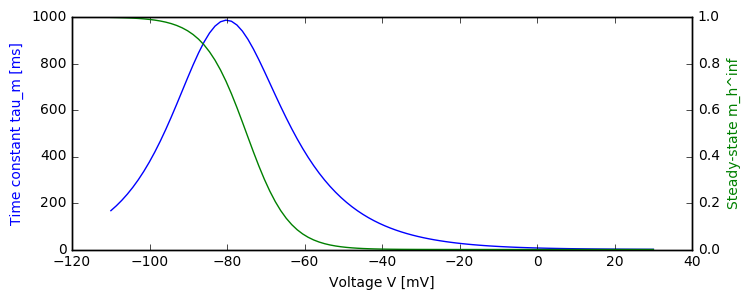

In [9]:
nest.ResetKernel()
ih = Ih(nest.GetDefaults('ht_neuron'))

V = np.linspace(-110, 30, 100)
plt.plot(V, ih.tau_m(V));
ax = plt.gca();
ax.set_xlabel('Voltage V [mV]');
ax.set_ylabel('Time constant tau_m [ms]', color='b');
ax2 = ax.twinx()
ax2.plot(V, ih.m_inf(V), 'g');
ax2.set_ylabel('Steady-state m_h^inf', color='g');

The time constant is extremely long, up to 1s, for relevant voltages where $I_h$ is perceptible. We thus need long test runs.

In [29]:
def voltage_clamp(channel, DT_V_seq, nest_dt=0.1, nest_equil=False):
    "Run voltage clamp with voltage V through intervals DT."

    # NEST part
    nest_g_0 = {'g_peak_h': 0., 'g_peak_T': 0., 'g_peak_NaP': 0., 'g_peak_KNa': 0.}
    nest_g_0[channel.nest_g] = 1.
    
    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': nest_dt})
    nrn = nest.Create('ht_neuron', params=nest_g_0)
    mm = nest.Create('multimeter', params={'record_from': ['V_m', 'theta', channel.nest_I],
                                           'interval': nest_dt})
    nest.Connect(mm, nrn)
    for DT, V in DT_V_seq:
        nest.SetStatus(nrn, {'V_m': V, 'voltage_clamp': True,
                            'equilibrate': nest_equil})
        nest.Simulate(DT)
    t_end = nest.GetKernelStatus()['time']
    
    # simulate a little more so we get all data up to t_end to multimeter
    nest.Simulate( 2 * nest.GetKernelStatus()['min_delay'])
    
    tmp = pd.DataFrame(nest.GetStatus(mm)[0]['events'])
    nest_res = tmp[tmp.times <= t_end]
    
    # Control part
    t_old, m_old = 0., channel.m_inf(nest.GetDefaults('ht_neuron')['V_m']) 
    t_all, I_all = [], []
    for DT, V in DT_V_seq:
        t_loc = np.arange(0., DT+0.1*nest_dt, nest_dt)
        I_loc = channel.compute_I(t_loc, m_old, V)
        t_all.extend(t_old + t_loc[1:])
        I_all.extend(I_loc[1:])
        m_old = channel.m[-1]
        t_old = t_all[-1]
        
    ctrl_res = pd.DataFrame({'times': t_all, channel.nest_I: I_all})
    
    return nest_res, ctrl_res

In [30]:
ih = Ih(nest.GetDefaults('ht_neuron'))
nr, cr = voltage_clamp(ih, 
                       [(500, -70.), (500, -80.), (500, -100.), (500, -90.), (500, -55.)]) 

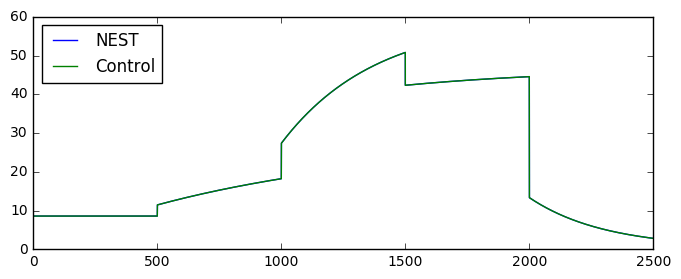

In [31]:
plt.plot(nr.times, nr.I_h, label='NEST');
plt.plot(cr.times, cr.I_h, label='Control');
plt.legend(loc='best');

In [32]:
len(nr.times), len(nr.I_h), len(cr.I_h)

(25000, 25000, 25000)

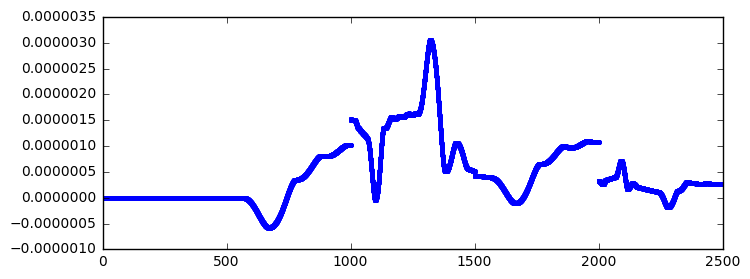

In [34]:
plt.plot(nr.times, nr.I_h-cr.I_h, '.');

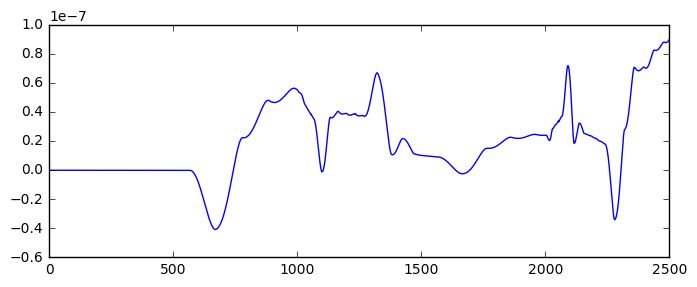

In [36]:
plt.plot(nr.times, (nr.I_h-cr.I_h)/np.abs(cr.I_h));

In [38]:
nr, cr = voltage_clamp(ih, 
                       [(500, -70.), (500, -80.), (500, -100.), (500, -90.), (500, -55.)],
                      nest_equil=True) 

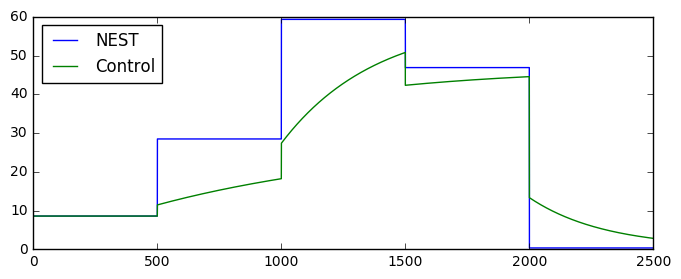

In [39]:
plt.plot(nr.times, nr.I_h, label='NEST');
plt.plot(cr.times, cr.I_h, label='Control');
plt.legend(loc='best');

In [40]:
nr, cr = voltage_clamp(ih, 
                       [(500, -70.), (500, -80.), (500, -100.), (500, -90.), (500, -55.)],
                      nest_dt=0.01) 

### Synapse Model

We test the synapse model by placing it between two parrot neurons, sending spikes with differing intervals and compare to expected weights.

In [18]:
nest.ResetKernel()
sp = nest.GetDefaults('ht_synapse')
P0 = sp['P']
dP = sp['delta_P']
tP = sp['tau_P']
spike_times = [10., 12., 20., 20.5, 100., 200., 1000.]
expected = [(0., P0, P0)]
for idx, t in enumerate(spike_times):
    tlast, Psend, Ppost = expected[idx]
    Psend = 1 - (1-Ppost)*math.exp(-(t-tlast)/tP)
    expected.append((t, Psend, (1-dP)*Psend))
expected_weights = list(zip(*expected[1:]))[1]

sg = nest.Create('spike_generator', params={'spike_times': spike_times})
n = nest.Create('parrot_neuron', 2)
wr = nest.Create('weight_recorder')

nest.SetDefaults('ht_synapse', {'weight_recorder': wr[0], 'weight': 1.0})
nest.Connect(sg, n[:1])
nest.Connect(n[:1], n[1:], syn_spec='ht_synapse')
nest.Simulate(1200)

rec_weights = nest.GetStatus(wr)[0]['events']['weights']

np.array(rec_weights) - np.array(expected_weights)


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

Perfect agreement, synapse model looks fine.